In [1]:
#https://engmrk.com/kerasapplication-pre-trained-model/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

import keras
import numpy as np
from keras.applications import resnet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

resnet_model = resnet50.ResNet50(weights='imagenet')

Using TensorFlow backend.


102858752/102853048 [==============================] - 3s 0us/step


# Training on MRI Data

In [0]:
# https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
files = glob.glob('/content/drive/My Drive/New folder/*') 

yes_files = [fn for fn in files if 'Y' in fn]
no_files = [fn for fn in files if 'no' in fn]
len(yes_files), len(no_files)

(155, 72)

In [4]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)

train_files = glob.glob('/content/drive/My Drive/New folder/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('/content/drive/My Drive/New folder/test/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
 '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (208, 300, 300, 3) 	Validation dataset shape: (45, 300, 300, 3)


(300, 300, 3)


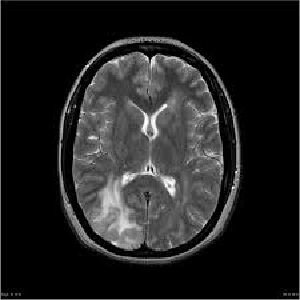

In [5]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0])

In [6]:
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[60:70], train_labels_enc[60:70])

['no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no'] [0 0 0 1 1 1 1 0 1 0]


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['no', 'no', 'no', 'no', 'no']


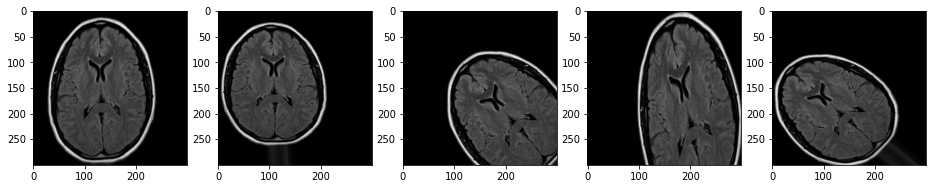

In [8]:
img_id = 60
no_brain_generator = train_datagen.flow(train_imgs[img_id:img_id+1], 
 train_labels[img_id:img_id+1], 
 batch_size=1) 
no_brain = [next(no_brain_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in no_brain]) 
l = [ax[i].imshow(no_brain[i][0][0]) for i in range(0,5)]

Labels: ['yes', 'yes', 'yes', 'yes', 'yes']


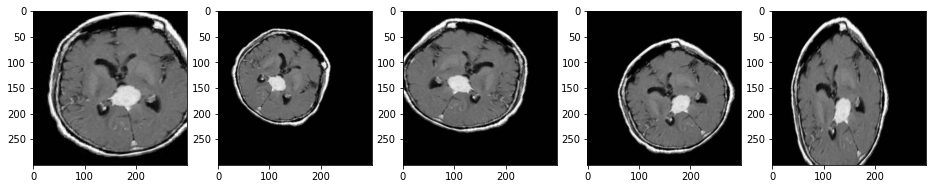

In [9]:
img_id = 64
yes_brain_generator = train_datagen.flow(train_imgs[img_id:img_id+1], 
 train_labels[img_id:img_id+1], 
 batch_size=1) 
yes_brain = [next(yes_brain_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in yes_brain]) 
l = [ax[i].imshow(yes_brain[i][0][0]) for i in range(0,5)]

In [0]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc,batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=30)

In [11]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
#restnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [12]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=restnet.input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 128,708,993
Trainable params: 105,121,281
Non-trainable params: 23,587,712
_______________________________

In [16]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=20, 
                              epochs=20,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              verbose=1)

Epoch 1/20
20/20 [==============================] - 13s 647ms/step - loss: 0.3281 - accuracy: 0.8620 - val_loss: 1.6721 - val_accuracy: 0.3333
Epoch 2/20
20/20 [==============================] - 13s 630ms/step - loss: 0.2678 - accuracy: 0.8809 - val_loss: 2.2198 - val_accuracy: 0.3333
Epoch 3/20
20/20 [==============================] - 12s 602ms/step - loss: 0.2667 - accuracy: 0.9088 - val_loss: 2.3829 - val_accuracy: 0.3333
Epoch 4/20
20/20 [==============================] - 12s 621ms/step - loss: 0.2637 - accuracy: 0.9074 - val_loss: 2.8449 - val_accuracy: 0.3333
Epoch 5/20
20/20 [==============================] - 13s 627ms/step - loss: 0.3768 - accuracy: 0.8754 - val_loss: 2.4504 - val_accuracy: 0.3333
Epoch 6/20
20/20 [==============================] - 12s 612ms/step - loss: 0.2598 - accuracy: 0.9010 - val_loss: 2.3670 - val_accuracy: 0.3333
Epoch 7/20
20/20 [==============================] - 12s 606ms/step - loss: 0.2235 - accuracy: 0.9209 - val_loss: 3.1928 - val_accuracy: 0.3333

In [14]:
print('\nhistory dict:', history.history)


history dict: {'val_loss': [0.7983071208000183, 0.6262019872665405, 0.6792956590652466, 0.7862005829811096, 0.6967426538467407, 1.0333410501480103, 1.05008864402771, 0.9916183948516846, 1.2528231143951416, 1.73502516746521], 'val_accuracy': [0.3333333432674408, 0.6666666865348816, 0.5333333611488342, 0.3333333432674408, 0.644444465637207, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408], 'loss': [1.0947348739362326, 0.672041639334425, 0.5833932270706703, 0.41372099925171246, 0.39925583086957867, 0.5021608383065522, 0.446913460489074, 0.371480663040471, 0.37926681078845004, 0.3850290664040402], 'accuracy': [0.65319866, 0.7323232, 0.75420874, 0.8299663, 0.8372483, 0.8080808, 0.83501685, 0.84511787, 0.8636364, 0.852349]}


In [17]:
print('\n# Evaluate on test data')
results = model.evaluate(validation_imgs, validation_labels_enc, batch_size=4)
print('test loss, test acc:', results)


# Evaluate on test data
45/45 [==============================] - 0s 10ms/step
test loss, test acc: [0.4438391479585941, 0.8666666746139526]


# Fine Tuning Attempt

In [19]:
restnet.trainable = True
set_trainable = False
for layer in restnet.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in restnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7f5c...,activation_50,False
...,...,...,...
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x7f5ca9aba240>,add_32,True
174,<keras.layers.core.Activation object at 0x7f5c...,activation_98,True


In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_finetuned = Sequential()
model_finetuned.add(restnet)
model_finetuned.add(Dense(512, activation='relu', input_dim=restnet.input_shape))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(512, activation='relu'))
model_finetuned.add(Dropout(0.3))
model_finetuned.add(Dense(1, activation='sigmoid'))
model_finetuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
model_finetuned.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 128,708,993
Trainable params: 108,536,833
Non-trainable params: 20,172,160
_______________________________

In [21]:
history_1 = model_finetuned.fit_generator(train_generator, 
                                  steps_per_epoch=20, 
                                  epochs=10,
                                  validation_data=val_generator, 
                                  validation_steps=20, 
                                  verbose=1)

Epoch 1/10
20/20 [==============================] - 17s 827ms/step - loss: 0.9119 - accuracy: 0.6128 - val_loss: 0.5855 - val_accuracy: 0.6667
Epoch 2/10
20/20 [==============================] - 14s 692ms/step - loss: 0.6341 - accuracy: 0.7138 - val_loss: 0.7945 - val_accuracy: 0.6667
Epoch 3/10
20/20 [==============================] - 13s 672ms/step - loss: 0.5234 - accuracy: 0.7601 - val_loss: 0.6431 - val_accuracy: 0.6444
Epoch 4/10
20/20 [==============================] - 13s 663ms/step - loss: 0.4610 - accuracy: 0.7845 - val_loss: 0.6969 - val_accuracy: 0.6667
Epoch 5/10
20/20 [==============================] - 13s 628ms/step - loss: 0.4350 - accuracy: 0.8074 - val_loss: 0.6686 - val_accuracy: 0.5111
Epoch 6/10
20/20 [==============================] - 12s 624ms/step - loss: 0.3684 - accuracy: 0.8490 - val_loss: 0.5217 - val_accuracy: 0.6667
Epoch 7/10
20/20 [==============================] - 13s 625ms/step - loss: 0.4519 - accuracy: 0.8114 - val_loss: 0.7286 - val_accuracy: 0.3778